In [33]:
#Importando as bibliotecas que possivelmente seráo usadas
import re
import numpy as np
import pandas as pd
import seaborn as sns
import math
from pprint import pprint
import unicodedata

# Importando a library Natural Language Toolkit - NLTK para tratamento de linguagem natural.
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans


#Importando as stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')# Download das stopworks do NLTK
language = 'portuguese'
stopwords = stopwords.words(language)
stopwords = list(set(stopwords))

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Plotagem
import spacy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from tqdm import tqdm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Importação da base licitação
licitacoes = pd.read_excel('C:/Users/012457631/Documents/AnaliseLicitacoes/LICITACOES.xlsx')
#Visualização das colunas da base licitação
licitacoes.head(2)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_COMISSAO,ANO_COMISSAO,TP_COMISSAO,NR_PROCESSO,ANO_PROCESSO,...,TP_DOCUMENTO_VENCEDOR,NR_DOCUMENTO_VENCEDOR,VL_HOMOLOGADO,BL_GERA_DESPESA,DS_OBSERVACAO,PC_TX_ESTIMADA,PC_TX_HOMOLOGADA,BL_COMPARTILHADA,BL_COVID19,LINK_LICITACON_CIDADAO
0,53100,PM DE NOVA PALMA,1,2021,TMP,6679.0,2018.0,P,30.0,2021,...,J,9.616070e+12,23734057.0,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...
1,86800,PM DE BOA VISTA DO SUL,2,2021,PRP,13.0,2021.0,G,6.0,2021,...,J,2.934210e+12,39000000.0,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...


In [3]:
#Reduzir escolhendo as colunas da base licitação a serem trabalhadas
licitacoes_valores=licitacoes[['NM_ORGAO', 'NR_LICITACAO', 'DIAS_DE_ESPERA','DT_HOMOLOGACAO', 'NR_PROCESSO', 'TP_OBJETO', 'TP_LICITACAO', 'DS_OBJETO', 'VL_LICITACAO', 'VL_HOMOLOGADO','BL_COVID19']]

<AxesSubplot:>

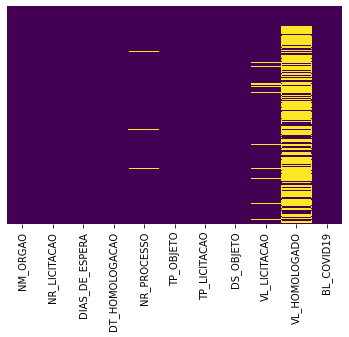

In [4]:
#Verificação de valores vazios
sns.heatmap(licitacoes_valores.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

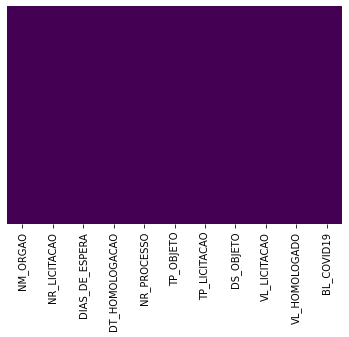

In [5]:
#Retirada dos vazios da base licitação
licitacoes_valores = licitacoes_valores.dropna()
#Verificação de valores vazios
sns.heatmap(licitacoes_valores.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [6]:
#Dados descritivos
licitacoes_valores.describe()

,NR_LICITACAO,DIAS_DE_ESPERA,NR_PROCESSO,VL_LICITACAO,VL_HOMOLOGADO
count,1.601500e+04,16015.000000,1.601500e+04,1.601500e+04,1.601500e+04
mean,6.172556e+10,10.041024,5.298510e+13,5.096664e+07,7.937284e+07
std,7.811331e+12,14.145359,6.556648e+14,5.767842e+08,3.932903e+09
min,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,-5.947200e+06
25%,7.000000e+00,0.000000,5.800000e+01,2.494275e+06,1.671040e+06
50%,2.100000e+01,5.000000,2.030000e+02,9.180000e+06,6.865500e+06
75%,5.800000e+01,13.000000,1.200000e+03,3.096427e+07,2.464248e+07
max,9.885270e+14,99.000000,8.202170e+15,6.750000e+10,3.719190e+11


In [7]:
#Agrupando por órgão
licitacoes_valores.groupby('NM_ORGAO')
#Salvando como uma nova variavel
por_orgao = licitacoes_valores.groupby("NM_ORGAO")

In [8]:
#Licitaçao de maior valor da base
licitacoes_valores[licitacoes_valores['VL_HOMOLOGADO']== licitacoes_valores['VL_HOMOLOGADO'].max()]
#O orgão que recebeu a licitação de maior valor homologado foi PM DE CRUZ ALTA

,NM_ORGAO,NR_LICITACAO,DIAS_DE_ESPERA,DT_HOMOLOGACAO,NR_PROCESSO,TP_OBJETO,TP_LICITACAO,DS_OBJETO,VL_LICITACAO,VL_HOMOLOGADO,BL_COVID19
29217,PM DE CRUZ ALTA,63,38,2021-06-08,63.0,CSE,MPR,AQUISIÇÃO DE GENEROS ALIMENTICIOS PARA SER UTI...,45480908.0,3.719190e+11,N


In [10]:
#Utilizando StopWords para reduzir e limpar os textos
nlp = spacy.load("pt_core_news_sm") # Uso do core do Spacy

nltk.download('stopwords') # Download das stopworks do NLTK
stopwords = nltk.corpus.stopwords.words('portuguese') # Carregamento das stopwords em português

# Caracteres especiais a serem deletados. Sendo unidades de medida e símbolos especiais que não agregam valor a análise
filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º','ja','viu','vai','ne','ai','ta','gente','nao','aqui','tambem','vc','voce','entao','ate','agora','ser','sempre','ter','so','porque','sobre','ainda','la','tudo','ninguem','de','do','da','para','pra']

# Função de tratamento
def processing_tokenization(sentence):
    sentence = sentence.lower() # Caixa baixa
    sentence = re.sub(r"[^\w\s]", "",sentence) # Exclusão de caracteres especiais
    sentence = re.sub("[0-9]+","", sentence) # Exclusão de dígitos
    sentence = re.sub("/+","", sentence) # Exclusão de "/"
    sentence = re.sub(' +', ' ', sentence) # Exclusão de espaçamentos repetitivos entre as frases

    doc=nlp(sentence) # Tokenização

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out] # Filtragem adicional com os caracteres em filter_out

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Aplicação do tratamento na lista de licitações e salvando os dados
licitacoes_valores['DS_OBJETO_TRATADO'] = licitacoes_valores['DS_OBJETO'].apply(lambda x: processing_tokenization(x))
#Passando para a base a coluna tratada
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_tratados3.csv'))

In [12]:
#licitacoes_valores.head(3)

In [13]:
# Aplicando a função na DS_OBJEO, countvectorizer faz a frequencia normal
bow_transformer = CountVectorizer(analyzer=processing_tokenization).fit(licitacoes_valores['DS_OBJETO'])
# Mostrando o tamanho do vocabulário
print(len(bow_transformer.vocabulary_))

16345


In [14]:
#Vetorização pela frequencia normal
messages_bow = bow_transformer.transform(licitacoes_valores['DS_OBJETO'])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:07<00:00, 12.48s/it]


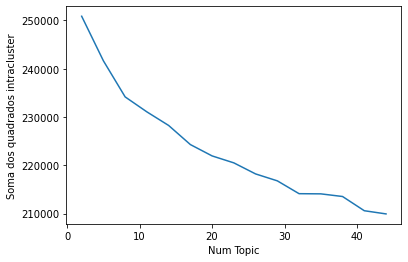

In [15]:
#O primeiro modelo a ser analisado é o Kmeans pois podemos ver a quantidade "razoavel" de clusters graficamente
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(messages_bow)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

In [16]:
kmeans_model = KMeans(n_clusters=20, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)
X = kmeans_model.fit(messages_bow)
labels=kmeans_model.labels_.tolist()
licitacoes_valores['Topicos_kmeans'] = labels
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_kmeans_27.csv'))

In [17]:
#Utilizando o modelo LDA para gerar os tópicos
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=27,random_state=42)
LDA.fit(messages_bow)

LatentDirichletAllocation(n_components=27, random_state=42)

In [18]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([bow_transformer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['distribuição', 'exclusividade', 'ferro', 'meepp', 'rs', 'computadores', 'instalação', 'abastecimento', 'materiais', 'interior', 'redes', 'rede', 'município', 'água', 'aquisição']


THE TOP 15 WORDS FOR TOPIC #1
['dispensa', 'ltda', 'contratada', 'reais', 'serviços', 'processo', 'cnpj', 'natal', 'total', 'sendo', 'mil', 'r', 'valor', 'contratação', 'empresa']


THE TOP 15 WORDS FOR TOPIC #2
['retroescavadeira', 'máquina', 'modelo', 'veículo', 'imediata', 'manutenção', 'motoniveladora', 'entrega', 'escavadeira', 'hidráulica', 'condicionado', 'ano', 'ar', 'peças', 'aquisição']


THE TOP 15 WORDS FOR TOPIC #3
['ano', 'limpeza', 'veículo', 'emenda', 'alegriars', 'obras', 'brita', 'desporto', 'saúde', 'município', 'cultura', 'educação', 'aquisição', 'municipal', 'secretaria']


THE TOP 15 WORDS FOR TOPIC #4
['preço', 'conforme', 'execução', 'regime', 'material', 'reforma', 'empreitada', 'global', 'escola', 'fornecimento', 'municipal', 'empresa', 'contratação',

In [19]:
topic_results = LDA.transform(messages_bow)
licitacoes_valores['Topicos_LDA'] = topic_results.argmax(axis=1)
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores__kmeans_LDA_27.csv'))

In [20]:
#Utilizano o modelo NMF para uma nova separação de tópicos
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=27,random_state=42)
nmf_model.fit(messages_bow)

NMF(n_components=27, random_state=42)

In [21]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([bow_transformer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['técnica', 'projeto', 'resíduos', 'elaboração', 'instalação', 'prestação', 'realizar', 'reforma', 'realização', 'construção', 'execução', 'fornecimento', 'especializada', 'contratação', 'empresa']


THE TOP 15 WORDS FOR TOPIC #1
['eventual', 'veículos', 'necessidade', 'entrega', 'despesa', 'preço', 'pregão', 'pneus', 'futura', 'peças', 'gás', 'medicamentos', 'equipamentos', 'uso', 'aquisição']


THE TOP 15 WORDS FOR TOPIC #2
['administração', 'aquisições', 'contados', 'fornecimento', 'sistema', 'doze', 'ata', 'futuras', 'preço', 'período', 'meses', 'futura', 'eventual', 'preços', 'registro']


THE TOP 15 WORDS FOR TOPIC #3
['total', 'serviços', 'compra', 'contratação', 'saúde', 'secretaria', 'subscrito', 'proveniente', 'responsável', 'memorando', 'via', 'solicitação', 'anexo', 'conforme', 'área']


THE TOP 15 WORDS FOR TOPIC #4
['meses', 'constantes', 'fornecimento', 'sistema', 'deste', 'através', 'presencial', 'pregão', 'especificações', 'edital', 'i', '

In [22]:
topic_resultsNMF = nmf_model.transform(messages_bow)
licitacoes_valores['Topicos_NMF'] = topic_resultsNMF.argmax(axis=1)
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_kmeans_LDA_NMF_27.csv'))

In [23]:
#licitacoes_valores.head(3)

In [24]:
#Com os 2 modelos salvos na base veremos como ficariam os seus respectivos tópicos utilizando a frequencia inversa TFIDF para vetorização
def identity_tokenizer(text):
    return text
vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(licitacoes_valores['DS_OBJETO_TRATADO'])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:13<00:00,  4.88s/it]


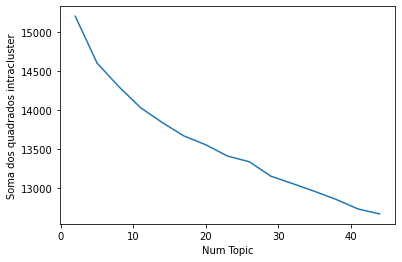

In [25]:
#O primeiro modelo a ser analisado é o Kmeans pois podemos ver a quantidade "razoavel" de clusters graficamente
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

In [26]:
kmeans_model = KMeans(n_clusters=28, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)
X = kmeans_model.fit(tfidf)
labels=kmeans_model.labels_.tolist()
licitacoes_valores['Topicos_kmeans'] = labels
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_kmeans_28.csv'))

In [27]:
#Utilizando o modelo LDA para gerar os tópicos
LDA = LatentDirichletAllocation(n_components=28,random_state=42)
LDA.fit(tfidf)

LatentDirichletAllocation(n_components=28, random_state=42)

In [28]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['veiculo', 'licitatório', 'eletrônico', 'van', 'capacidade', 'item', 'equipamento', 'secretaria', 'pregão', 'novo', 'aquisição', 'zero', 'km', 'tipo', 'veículo']


THE TOP 15 WORDS FOR TOPIC #1
['sonorização', 'evento', 'aquisição', 'empresa', 'natalina', 'básica', 'decoração', 'gramado', 'mobiliário', 'unidade', 'montagem', 'confecção', 'processo', 'natal', 'adm']


THE TOP 15 WORDS FOR TOPIC #2
['aquisição', 'acordo', 'gabinete', 'alta', 'i', 'constantes', 'notebooks', 'ii', 'especificações', 'anexo', 'edital', 'constitui', 'licitação', 'objeto', 'presente']


THE TOP 15 WORDS FOR TOPIC #3
['epis', 'ambiente', 'meio', 'prevenção', 'saúde', 'convênio', 'agricultura', 'equipamentos', 'municipal', 'hospitalar', 'n', 'secretaria', 'proteção', 'aquisição', 'material']


THE TOP 15 WORDS FOR TOPIC #4
['projeto', 'trecho', 'conforme', 'material', 'mão', 'bairro', 'regime', 'contratação', 'empresa', 'pavimentação', 'obra', 'empreitada', 'global', 'execução', 'r

In [29]:
topic_results_tfidf_LDA = LDA.transform(tfidf)
licitacoes_valores['Topicos_tfidf_LDA'] = topic_results_tfidf_LDA.argmax(axis=1)
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_tfidf_kmeans_LDA_28.csv'))

In [30]:
#Utilizano o modelo NMF para uma nova separação de tópicos
nmf_model = NMF(n_components=28,random_state=42)
nmf_model.fit(tfidf)

NMF(n_components=28, random_state=42)

In [31]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['cestas', 'generos', 'covid', 'instalação', 'descartáveis', 'máscaras', 'lubrificantes', 'uso', 'sms', 'uniformes', 'móveis', 'retroescavadeira', 'fraldas', 'req', 'aquisição']


THE TOP 15 WORDS FOR TOPIC #1
['consultoria', 'prestação', 'projeto', 'assessoria', 'gestão', 'contratacao', 'instalação', 'elaboração', 'execução', 'realizar', 'locação', 'realização', 'especializada', 'contratação', 'empresa']


THE TOP 15 WORDS FOR TOPIC #2
['n', 'serviços', 'contratação', 'compra', 'secretaria', 'conforme', 'anexo', 'saúde', 'área', 'solicitação', 'via', 'memorando', 'responsável', 'proveniente', 'subscrito']


THE TOP 15 WORDS FOR TOPIC #3
['eventuais', 'visando', 'hamburgo', 'validade', 'doze', 'período', 'ata', 'sob', 'parceladas', 'sistema', 'meses', 'aquisições', 'futuras', 'registro', 'preços']


THE TOP 15 WORDS FOR TOPIC #4
['compreendendo', 'mao', 'caminhão', 'substituição', 'garantia', 'processo', 'adm', 'incluindo', 'necessários', 'conserto', 'peça

In [32]:
topic_results_tfidf_NMF = nmf_model.transform(tfidf)
licitacoes_valores['Topicos_tfidf_NMF'] = topic_results_tfidf_NMF.argmax(axis=1)
licitacoes_valores.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/licitacoes_valores_tfidf_kmeans_LDA_NMF_28.csv'))

In [42]:
#Inserção das bases para analises
LicitacoesTopicosVF = pd.read_excel('C:/Users/012457631/Documents/AnaliseLicitacoes/LicitacoesVF.xlsx')
LicitacoesRenomeadas = pd.read_excel('C:/Users/012457631/Documents/AnaliseLicitacoes/Licitacoes_renomeadas.xlsx')
BaseLicitacoes=pd.merge(LicitacoesTopicosVF,LicitacoesRenomeadas,how='inner',on='Topicos_NMF')

In [45]:
#Gerando as culunas de ANO E MES
from datetime import datetime
BaseLicitacoes['DT_HOMOLOGACAO'] =  pd.to_datetime(BaseLicitacoes['DT_HOMOLOGACAO'], format='%d/%m/%Y')
BaseLicitacoes['ANO'] = BaseLicitacoes['DT_HOMOLOGACAO'].dt.year
BaseLicitacoes['MES'] = BaseLicitacoes['DT_HOMOLOGACAO'].dt.month

In [47]:
BaseLicitacoes['Motivos'].value_counts().head(26)

Aquisição de materiais gerais                                 2763
Registro de preços                                            2096
Recuperação/manutenção de estabelecimentos                    1164
Serviços de manutenção geral                                  1145
Serviços especializados                                       1070
Fornecedoras de mão de obra especializada                      925
Tratamento de esgoto/água                                      594
Manutenção de áreas publicas (abertas)                         593
Serviços de locomoção                                          533
Manutenção asfáltica                                           493
Contratação de empresa em regime de empreiteira global         394
Serviços/aquisições hospitalares                               392
Ampliação/reforma de estabelecimentos                          381
Serviços da área da saúde                                      338
Outros                                                        

In [61]:
BaseLicitacoes.groupby('Motivos').mean()['VL_HOMOLOGADO'].head(3)
#O motivo de maior arrecadação monetária em média doi o de "Administração/monitoramento de estabelecimentos e serviços"

Motivos
Administração/monitoramento de estabelecimentos e serviços    1.679523e+08
Ampliação/reforma de estabelecimentos                         3.073158e+08
Aquisição de generos alimentícios                             2.078709e+08
Name: VL_HOMOLOGADO, dtype: float64

<AxesSubplot:xlabel='MES', ylabel='count'>

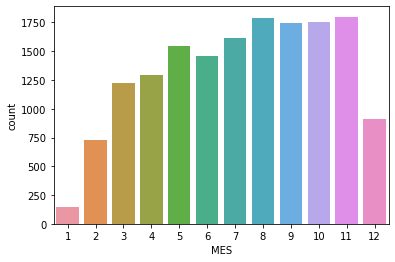

In [49]:
#Gráfico visão geral por mes
sns.countplot(x='MES',data=BaseLicitacoes)

In [58]:
#No gráfico acima podemos observar pouca variação na quantidade de licitações entre agosto e novembro
BaseLicitacoes.groupby('MES').mean()['VL_HOMOLOGADO'].head(12)
#O mes com maior arrecadação monetária (média) foi Junho

MES
1     1.959169e+08
2     3.068879e+08
3     2.839717e+08
4     3.060824e+08
5     3.645388e+08
6     5.154635e+09
7     2.926995e+08
8     4.441121e+08
9     3.780489e+08
10    3.090605e+08
11    4.271779e+08
12    4.315008e+08
Name: VL_HOMOLOGADO, dtype: float64

In [62]:
#Conclusões Gerais:
#O modelo com melhor tratamento e divisão de dados foi o de bag of word + Non-negative Matrix Factorization(NMF)
#Nesse estudo repartimos os dados em 26 clusters distintos sendo um de "Outros"
#pois não foi possível encontrar um padrão para recodificar o mesmo
#Para a análise foram usadas os valores monetários e de data homologados pois são os valores considerados finais, oficiais
#Apesar do motivo de aquisições estar no topo, houveram mais licitações relacionadas a contratatação de empresas e serviços
#que aquisição de materiais/insumos
#Ao analisar os clusters é possível ver forte presença de contratação para obras (construção, reforma, pavimentção...) e aquisição de materiais para as mesmas